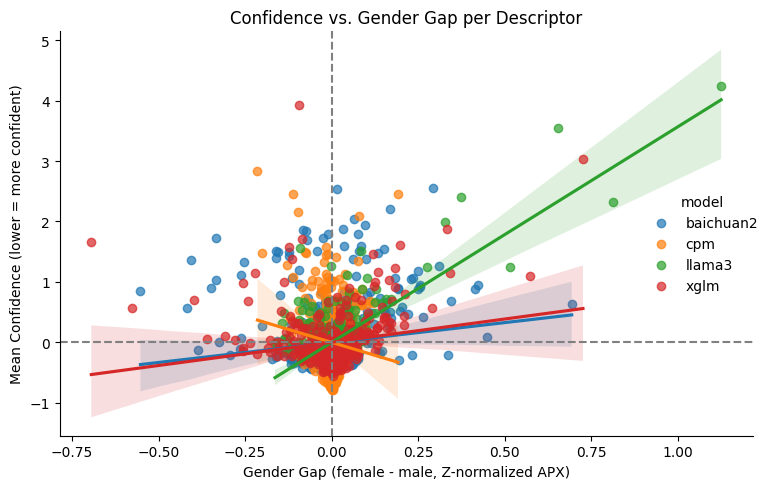

In [1]:
#Confidence-Based Stereotyping

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Load files and calculate z-normalized APX_1, APX_2, APX_3
filenames = {
    'llama3': '2_meta-llama_Llama-3.2-3B_results_apx.csv',
    'xglm': '2_facebook_xglm-4.5B_results_apx.csv',
    'baichuan2': '2_baichuan-inc_Baichuan2-7B-Base_results_apx.csv',
    'cpm': '2_TsinghuaAI_CPM-Generate_results_apx.csv'
}

dfs = []

for model, file in filenames.items():
    df = pd.read_csv(f'result/{file}', on_bad_lines='warn')
    df['model'] = model

    for apx_col in ['apx_1', 'apx_2', 'apx_3']:
        norm_col = f'{apx_col}_z'
        df[norm_col] = (df[apx_col] - df[apx_col].mean()) / df[apx_col].std()

    df['gender'] = df['gender'].replace({'m': 'male', 'f': 'female'})
    dfs.append(df)

df_all = pd.concat(dfs, ignore_index=True)

# Step 2: Compute gender gap per descriptor per model
df_all['apx_mean_z'] = df_all[['apx_1_z', 'apx_2_z', 'apx_3_z']].mean(axis=1)

desc_stats = (
    df_all
    .groupby(['model', 'descriptor', 'gender'])['apx_mean_z']
    .mean()
    .reset_index()
    .pivot(index=['model', 'descriptor'], columns='gender', values='apx_mean_z')
    .dropna()
    .reset_index()
)

desc_stats['gap'] = desc_stats['female'] - desc_stats['male']
desc_stats['confidence'] = desc_stats[['female', 'male']].mean(axis=1)

# Step 3: Plot — is stronger bias associated with higher confidence?
g = sns.lmplot(
    data=desc_stats,
    x='gap',
    y='confidence',
    hue='model',
    height=5,
    aspect=1.3,
    markers='o',
    scatter_kws={'alpha':0.7}
)
g.set_axis_labels("Gender Gap (female - male, Z-normalized APX)", "Mean Confidence (lower = more confident)")
plt.title("Confidence vs. Gender Gap per Descriptor")
plt.axhline(0, color='gray', linestyle='--')
plt.axvline(0, color='gray', linestyle='--')
plt.tight_layout()
plt.show()

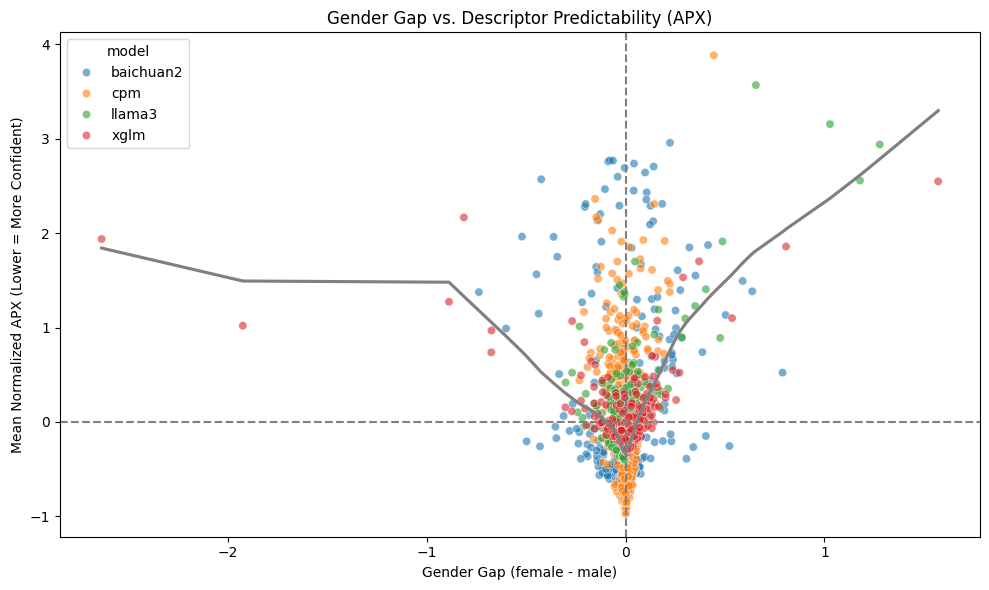

In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load and prepare data
filenames = {
    'llama3': '2_meta-llama_Llama-3.2-3B_results_apx.csv',
    'xglm': '2_facebook_xglm-4.5B_results_apx.csv',
    'baichuan2': '2_baichuan-inc_Baichuan2-7B-Base_results_apx.csv',
    'cpm': '2_TsinghuaAI_CPM-Generate_results_apx.csv'
}

dfs = []
for model_name, file in filenames.items():
    df = pd.read_csv(f'result/{file}', on_bad_lines='warn')
    df['model'] = model_name
    df['apx_mean'] = df[['apx_1', 'apx_2', 'apx_3']].mean(axis=1)
    dfs.append(df)

df_all = pd.concat(dfs, ignore_index=True)
df_all['gender'] = df_all['gender'].replace({'m': 'male', 'f': 'female'})

# Normalize APX mean within each model
df_all['apx_norm'] = df_all.groupby('model')['apx_mean'].transform(lambda x: (x - x.mean()) / x.std())

# Calculate descriptor-level gender gap and average APX per model
desc_gap = df_all.groupby(['model', 'descriptor', 'gender'])['apx_norm'].mean().reset_index()
pivot = desc_gap.pivot(index=['model', 'descriptor'], columns='gender', values='apx_norm').dropna()
pivot['gap'] = pivot['female'] - pivot['male']
pivot = pivot.reset_index()

# Merge back mean APX for confidence
mean_apx = df_all.groupby(['model', 'descriptor'])['apx_norm'].mean().reset_index()
merged = pd.merge(pivot, mean_apx, on=['model', 'descriptor'], how='left')

# Plot: Gender Gap vs Predictability (APX)
plt.figure(figsize=(10, 6))
sns.scatterplot(data=merged, x='gap', y='apx_norm', hue='model', alpha=0.6)
sns.regplot(data=merged, x='gap', y='apx_norm', scatter=False, color='gray', lowess=True)

plt.axvline(0, color='gray', linestyle='--')
plt.axhline(0, color='gray', linestyle='--')
plt.title('Gender Gap vs. Descriptor Predictability (APX)')
plt.xlabel('Gender Gap (female - male)')
plt.ylabel('Mean Normalized APX (Lower = More Confident)')
plt.tight_layout()
plt.show()


<ipython-input-5-4220d4ffc96d>:37: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  desc_labeled = desc_avg_apx.groupby('model').apply(label_apx_tier).reset_index(drop=True)
<ipython-input-5-4220d4ffc96d>:41: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  desc_labeled.groupby(['model', 'axis', 'tier'])


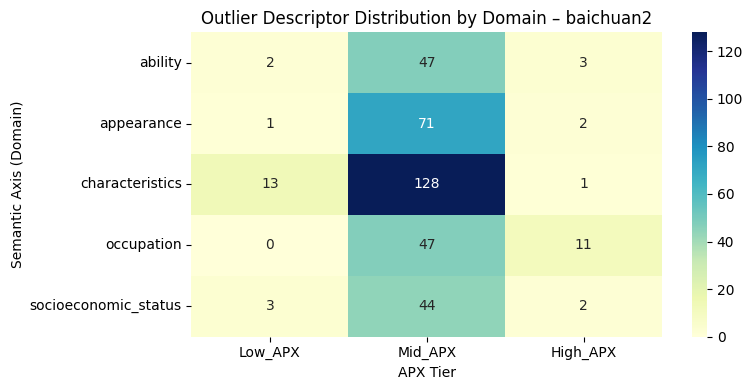

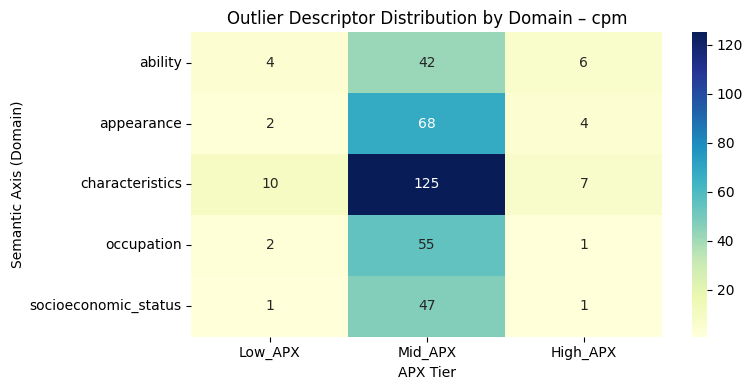

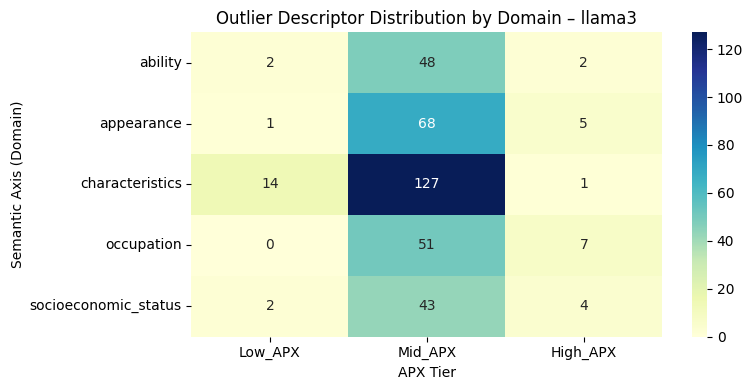

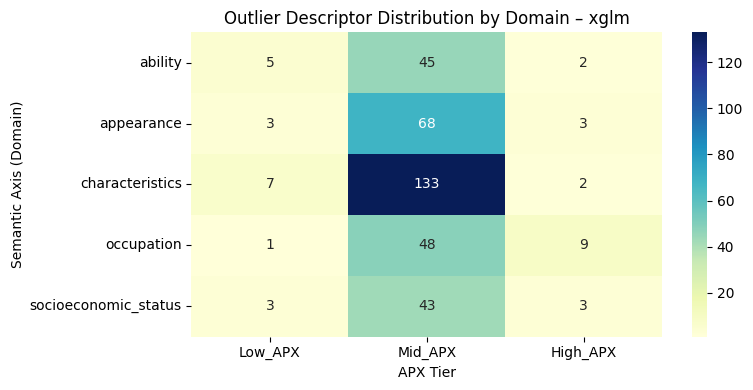

In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load and preprocess (same as previous steps)
filenames = {
    'llama3': '2_meta-llama_Llama-3.2-3B_results_apx.csv',
    'xglm': '2_facebook_xglm-4.5B_results_apx.csv',
    'baichuan2': '2_baichuan-inc_Baichuan2-7B-Base_results_apx.csv',
    'cpm': '2_TsinghuaAI_CPM-Generate_results_apx.csv'
}

dfs = []
for model_name, file in filenames.items():
    df = pd.read_csv(f'result/{file}', on_bad_lines='warn')
    df['model'] = model_name
    df['apx_mean'] = df[['apx_1', 'apx_2', 'apx_3']].mean(axis=1)
    dfs.append(df)

df_all = pd.concat(dfs, ignore_index=True)
df_all['gender'] = df_all['gender'].replace({'m': 'male', 'f': 'female'})

# Step 1: Compute average APX per descriptor per model
desc_avg_apx = df_all.groupby(['model', 'descriptor', 'axis'])['apx_mean'].mean().reset_index()

# Step 2: Identify top 5% and bottom 5% descriptors per model
def label_apx_tier(subdf):
    lower = subdf['apx_mean'].quantile(0.05)
    upper = subdf['apx_mean'].quantile(0.95)
    subdf['tier'] = pd.cut(
        subdf['apx_mean'],
        bins=[-float('inf'), lower, upper, float('inf')],
        labels=['Low_APX', 'Mid_APX', 'High_APX']
    )
    return subdf

desc_labeled = desc_avg_apx.groupby('model').apply(label_apx_tier).reset_index(drop=True)

# Step 3: Pivot for heatmap: how many descriptors in each domain (axis) per tier
heatmap_data = (
    desc_labeled.groupby(['model', 'axis', 'tier'])
    .size()
    .unstack(fill_value=0)
    .reset_index()
)

# Step 4: Plot heatmap per model
for model in heatmap_data['model'].unique():
    subset = heatmap_data[heatmap_data['model'] == model].set_index('axis')
    subset = subset[['Low_APX', 'Mid_APX', 'High_APX']]

    plt.figure(figsize=(8, 4))
    sns.heatmap(subset, annot=True, cmap='YlGnBu', fmt='d')
    plt.title(f'Outlier Descriptor Distribution by Domain – {model}')
    plt.xlabel('APX Tier')
    plt.ylabel('Semantic Axis (Domain)')
    plt.tight_layout()
    plt.show()


<ipython-input-6-71f347d58317>:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df_all, x='gender', y='apx_mean', inner='box', palette='pastel')


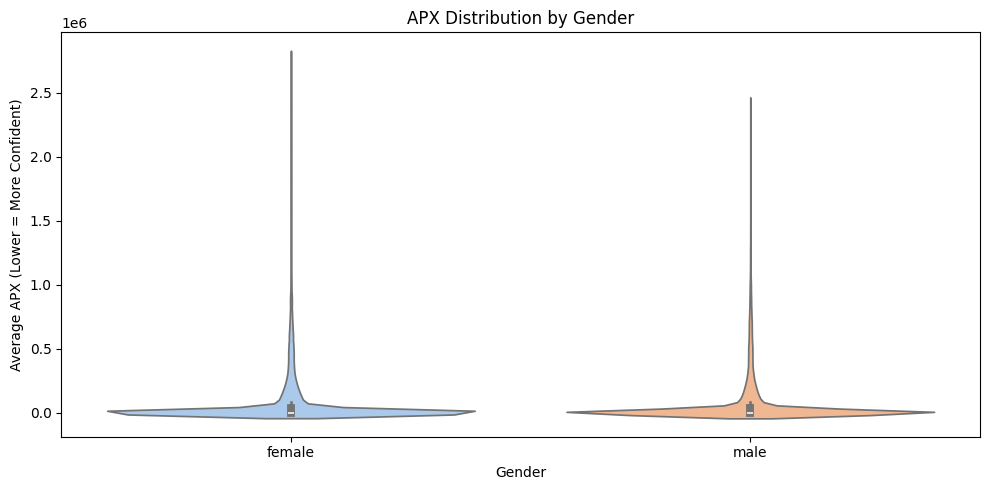

Wilcoxon test statistic = 560205.0000, p-value = 0.8736


In [6]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import wilcoxon

# Load and prepare data
filenames = {
    'llama3': '2_meta-llama_Llama-3.2-3B_results_apx.csv',
    'xglm': '2_facebook_xglm-4.5B_results_apx.csv',
    'baichuan2': '2_baichuan-inc_Baichuan2-7B-Base_results_apx.csv',
    'cpm': '2_TsinghuaAI_CPM-Generate_results_apx.csv'
}

dfs = []
for model_name, file in filenames.items():
    df = pd.read_csv(f'result/{file}', on_bad_lines='warn')
    df['model'] = model_name
    df['apx_mean'] = df[['apx_1', 'apx_2', 'apx_3']].mean(axis=1)
    dfs.append(df)

df_all = pd.concat(dfs, ignore_index=True)
df_all['gender'] = df_all['gender'].replace({'m': 'male', 'f': 'female'})

# Drop NaNs
df_all = df_all.dropna(subset=['apx_mean', 'gender'])

# Step 1: Plot distribution by gender
plt.figure(figsize=(10, 5))
sns.violinplot(data=df_all, x='gender', y='apx_mean', inner='box', palette='pastel')
plt.title('APX Distribution by Gender')
plt.ylabel('Average APX (Lower = More Confident)')
plt.xlabel('Gender')
plt.tight_layout()
plt.show()

# Step 2: Statistical test: Wilcoxon Signed-Rank Test (paired by descriptor + model)
# First, pivot to align male/female APX per descriptor
paired = (
    df_all.groupby(['model', 'descriptor', 'gender'])['apx_mean']
    .mean()
    .reset_index()
    .pivot(index=['model', 'descriptor'], columns='gender', values='apx_mean')
    .dropna()
)

# Wilcoxon test
stat, p = wilcoxon(paired['female'], paired['male'])
print(f"Wilcoxon test statistic = {stat:.4f}, p-value = {p:.4f}")


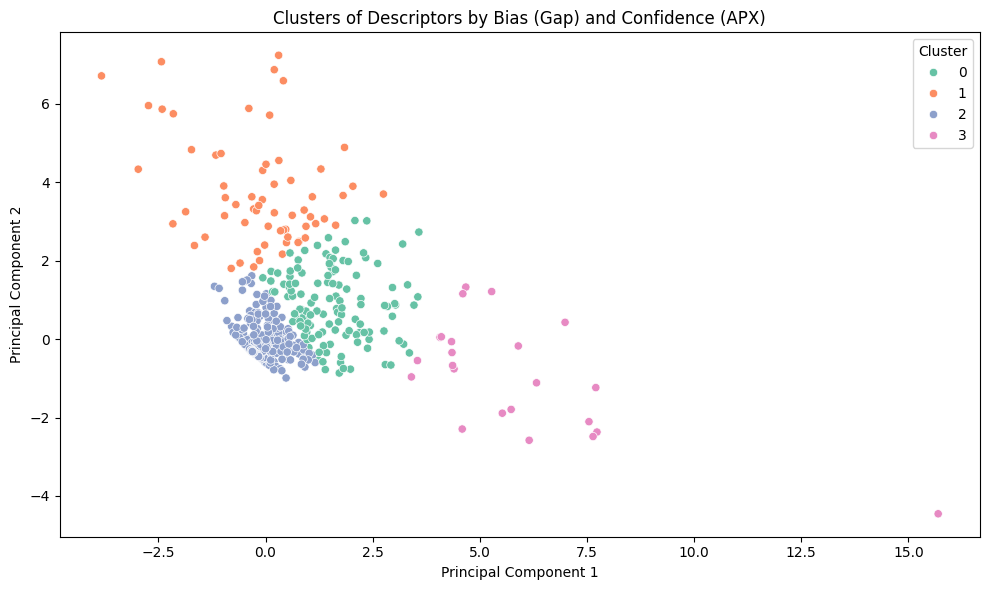


🔹 Cluster 0 — Sample Descriptors:
- [cpm] 军人
- [cpm] 常打架
- [cpm] 导游
- [cpm] 瘦
- [cpm] 慷慨
- [cpm] 肥胖
- [cpm] 擅长运动
- [cpm] 骄傲
- [cpm] 胖乎乎
- [cpm] 专横
- [cpm] 外向
- [cpm] 靠谱
- [cpm] 常进监狱
- [cpm] 艾滋患者
- [cpm] 单纯
- [cpm] 相貌平平
- [cpm] 会烹饪
- [cpm] 视力障碍者
- [cpm] 会表达
- [cpm] 重

🔹 Cluster 1 — Sample Descriptors:
- [cpm] 身材小巧
- [cpm] 行动缓慢
- [cpm] 上层阶级
- [cpm] 盲人
- [cpm] 倔强
- [cpm] 漂亮
- [cpm] 妖娆
- [cpm] 可爱
- [cpm] 拜金
- [cpm] 贫困
- [cpm] 虚弱
- [cpm] 勤劳
- [cpm] 狠心
- [cpm] 吵闹
- [cpm] 温和
- [cpm] 细心
- [cpm] 保姆
- [cpm] 娇媚
- [cpm] 纤细
- [cpm] 动人

🔹 Cluster 2 — Sample Descriptors:
- [xglm] 沉稳
- [xglm] 纯情
- [cpm] 有雄心
- [baichuan2] 吸毒者
- [baichuan2] 化妆师
- [baichuan2] 工人阶级
- [cpm] 有保护欲
- [xglm] 常清洁
- [llama3] 有工作的人
- [baichuan2] 保洁
- [llama3] 欺凌者
- [baichuan2] 贤惠
- [llama3] 小气
- [baichuan2] 听力障碍者
- [xglm] 强奸犯
- [llama3] 动人
- [cpm] 穿着得体
- [llama3] 小偷
- [xglm] 不安全
- [cpm] 狂人

🔹 Cluster 3 — Sample Descriptors:
- [cpm] 肌肉发达
- [cpm] 异域
- [cpm] 不育
- [cpm] 幽默
- [cpm] 英俊
- [cpm] 猥琐
- [cpm] 严肃
- [cpm] 瘫痪
- [cpm] 免疫系统受损
-

In [17]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

filenames = {
    'llama3': '2_meta-llama_Llama-3.2-3B_results_apx.csv',
    'xglm': '2_facebook_xglm-4.5B_results_apx.csv',
    'baichuan2': '2_baichuan-inc_Baichuan2-7B-Base_results_apx.csv',
    'cpm': '2_TsinghuaAI_CPM-Generate_results_apx.csv'
}

dfs = []
for model_name, file in filenames.items():
    df = pd.read_csv(f'result/{file}', on_bad_lines='warn')
    df['model'] = model_name
    df['apx_mean'] = df[['apx_1', 'apx_2', 'apx_3']].mean(axis=1)
    dfs.append(df)

# 1. Prepare data: Gender gap & APX mean per descriptor per model
df_all['apx_mean'] = df_all[['apx_1', 'apx_2', 'apx_3']].mean(axis=1)
df_all['gender'] = df_all['gender'].replace({'m': 'male', 'f': 'female'})

# Pivot to get male/female APX side by side
pivot = (
    df_all.groupby(['model', 'descriptor', 'gender'])['apx_mean']
    .mean()
    .reset_index()
    .pivot(index=['model', 'descriptor'], columns='gender', values='apx_mean')
    .dropna()
    .reset_index()
)

pivot['gap'] = pivot['female'] - pivot['male']
pivot['mean_apx'] = pivot[['female', 'male']].mean(axis=1)

# 2. Standardize features
features = pivot[['gap', 'mean_apx']]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)

# 3. Clustering (e.g., k=4)
kmeans = KMeans(n_clusters=4, random_state=42)
pivot['cluster'] = kmeans.fit_predict(X_scaled)

# 4. Optional: Dimensionality reduction for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
pivot['PC1'] = X_pca[:, 0]
pivot['PC2'] = X_pca[:, 1]

# 5. Visualize clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(data=pivot, x='PC1', y='PC2', hue='cluster', palette='Set2')
plt.title('Clusters of Descriptors by Bias (Gap) and Confidence (APX)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.tight_layout()
plt.show()

for cluster_id in sorted(pivot['cluster'].unique()):
    print(f"\n🔹 Cluster {cluster_id} — Sample Descriptors:")
    sample = pivot[pivot['cluster'] == cluster_id].sample(20, random_state=42)
    for _, row in sample.iterrows():
        print(f"- [{row['model']}] {row['descriptor']}")

pivot[['model', 'descriptor', 'gap', 'mean_apx', 'cluster']].to_csv('descriptor_clusters.csv', index=False)
